### Author: Sitges i Puy, Guillem

Computing Lab, Data Science program BGSE
October 2018, 23rd

# A study of vehicle accidents in the UK

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np
import datetime

import folium
from folium import plugins
from folium.plugins import MarkerCluster
import statsmodels.api as sm




### Loading data

In [2]:
accidents = pd.read_csv("../module-computing/Data-SMALL-2014/Accidents_2014_categorical_small.csv")
vehicles = pd.read_csv("../module-computing/Data-SMALL-2014/Vehicles_2014_categorical_small.csv") 
casualties = pd.read_csv("../module-computing/Data-SMALL-2014/Casualties_2014_categorical_small.csv")
accidentsAll = pd.read_csv("../module-computing/Data_FULL-2005-2015/Accidents_2005-2015_categorical.csv")
vehiclesAll = pd.read_csv("../module-computing/Data_FULL-2005-2015/Vehicles_2005-2015_categorical.csv")
casualtiesAll = pd.read_csv("../module-computing/Data_FULL-2005-2015/Casualties_2005-2015_categorical.csv")

# 1. How accidents are spread over the territory

The following graph shows an overview of the number of accidents by district in 2014.

In [3]:
accbydistrict = accidents.groupby('Local_Authority_(District)').agg({ 'Accident_Index':'count'})
accbydistrict = pd.DataFrame(accbydistrict)
accbydistrict = accbydistrict.reset_index()

accbydistrict.columns = ['name', 'accidents']


In [4]:
accbydistrict = accbydistrict.set_index('name').accidents

In [10]:
import urllib.request, json 
import branca



m2 = folium.Map(location=[53.5123, -0.0910], 
               zoom_start=6)



colorscale = branca.colormap.linear.YlOrRd_09.scale(accbydistrict.min(), accbydistrict.max())
def style_function(feature):
    district_name = feature['properties']['LAD13NM']
    if district_name in accbydistrict.index:
        value = accbydistrict[district_name]
    else: 
        value = None
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black' if value is None else colorscale(value)
    }


folium.TopoJson(
     open("../ComputingLab/topo_lad.json"),
    'objects.lad',
    style_function=style_function
).add_to(m2)

folium.LayerControl().add_to(m2)
m2



## 1.1 Takeaway

Darker colors correspond to higher number of accidents. As we can observe, big urban areas have higher number of accidents compared to rural area.
Surprisingly, London does not show the darkest areas. However, we should take into account that London metropolitan area is divided in multiple local authority districts. Thus, if we would plot the density of accidents (accident per km2), we would probably find the highest density in London areas. 
Black areas refers to those districts without information on accidents.

## 2. Where did the accidents in the City of London took place in 2014?

We will further analyse the location of accidents by restricting our data to the City of London.

In [11]:
accCityLond = accidents[accidents['Local_Authority_(District)'] == 'City of London']

 The total number of accidents in the City of London in 2014 was:

In [12]:
len(accCityLond.index)

348

In the following map we observe where the accidents took place:

In [13]:
m = folium.Map([51.5123, -0.0910], 
               zoom_start=14)
locations = accCityLond[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()

marker_cluster = MarkerCluster().add_to(m)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)

In [14]:
m

## 2.1 Takeaway

The total number of accidents in the City of London in 2014 was 348

The locations with a higher number of accidents are:

- Liverpool Street Station
    
- Monument area
    
- Junction New Bridge Street / Ludgate Hill


# 3. How does fatigue affect accidents?

On the following analysis, we will explore how fatigue affects accidents. We could expect that the number of accidents increase as we approach the weekend because people is more tired.

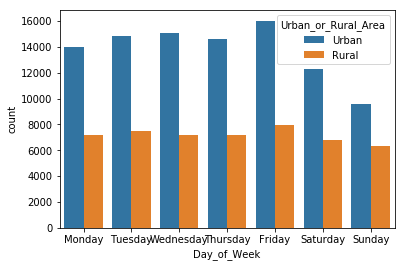

In [15]:
sns.countplot(data = accidents, x= accidents.Day_of_Week, order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], hue =  accidents.Urban_or_Rural_Area)

There is a higher number of accident on Friday. However, fatigue may also has an impact within the day. That is to say, althought density of traffic is similar during commuting ours (morning and afternoon), we will find a higher number of accidents in the afternoon as people is tired from working the whole day.

In [16]:
#Let's create a cathegorical variable (in minutes):
#-Night time 1: 00.00 - 06.00 (0-360)
#-Morning commuting: 6.00 - 10.00 (360 - 600)
#-Working time: 10.00 - 15.00 (600 - 900)
#-Afternoon commuting: 15.00 - 21.00 (900 - 1260)
#Night time 2: 21.00 - 24.00 (1260 - 1440)

In [17]:
#This code creates the five cathegories as described above

accidents['Time_in_minutes'] = accidents['Time'].str.split(':')

accidents['Time_in_minutes'] = (accidents['Time_in_minutes'].str.get(0).astype(float))*60 + accidents['Time_in_minutes'].str.get(1).astype(float)

bins = [0, 360, 600, 900, 1260, np.inf]
names = ['Night time 1', 'Morning commuting', 'Working time', 'Afternoon commuting', 'Night time 2']

accidents['TimeRange'] = pd.cut(accidents['Time_in_minutes'], bins, labels=names)

The following plot shows the number of accident by weekday in different time periods.

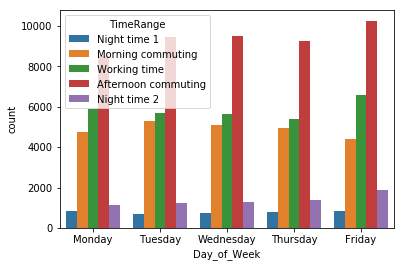

In [18]:
sns.countplot(data = accidents, x= accidents.Day_of_Week, order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], hue =  accidents.TimeRange)

Finally, we want to inspect the differences between weekdays and weekend on the within day fatigue:

/home/gsitges/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


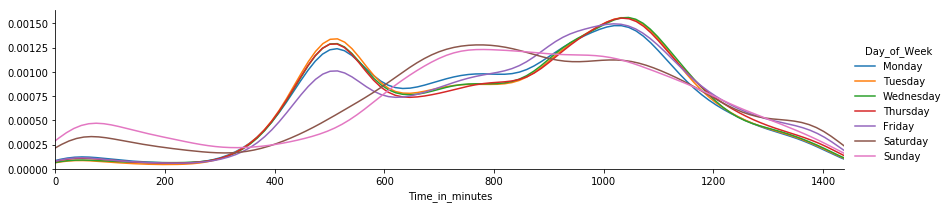

In [19]:
g = sns.FacetGrid(accidents, hue="Day_of_Week",aspect = 4, hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'])
bins = np.arange(0, 24, 4)
g.map(sns.kdeplot,'Time_in_minutes',shade= False)
g.set(xlim=(0, accidents['Time_in_minutes'].max()))
g.add_legend()


#labels = ['00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','24:00']

g.set_xticklabels()



plt.show()

## 3.1 Takeaway

The data supports our hypothesis that fatigue increases the number of accidents both withtin a day and along the week.
We found evidences that there is a higher number of accidents on Friday (Graph1) and in the afternoon (Graph2).
Moreover, supporting the idea of Graph2, we found that there is not such a fatigue effect during weekends. Thus, number of accidents is spread along the day more smoothly on Saturday and Sunday (Graph3).
However, further analysis should be done because it exists the possibility that higher number of accidents in the afternoon are caused by the .. of people to arrive earlier at home. One possible study would be to explore speed limit violations in the afternoon compared to the morning.

# 4. What is a typicall accident for a right-hand driven vehicle?

In [20]:
#merging accidents with vehicles

accveh = pd.merge(accidents, vehicles)

In [21]:
#converting Date column to datetime
accveh['Date'] = pd.to_datetime(accveh['Date'], dayfirst = True)

In [22]:
#converting Date to ordinal
accveh['ordinal'] = accveh['Date'].apply(lambda x: x.toordinal())

In [23]:
#dataset only for right-hand driven cars
accvehYes = accveh[accveh['Was_Vehicle_Left_Hand_Drive?'] == 'Yes']

In [24]:
accvehYes.sort_values(by=['ordinal'])

,Accident_Index,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,...,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_Home_Area_Type,ordinal
242643,201460R000639,-4.239799,53.224113,North Wales,Slight,2,1,2014-01-01,Wednesday,23:40,...,Yes,Journey as part of work,Male,61,9,-1,-1,-1,Data missing or out of range,735234
68407,2014074001394,-2.127809,53.264912,Cheshire,Slight,2,1,2014-01-01,Wednesday,03:16,...,Yes,Journey as part of work,Male,-1,-1,2402,Heavy oil,11,Urban area,735234
143717,2014331400027,-1.321977,52.824080,Leicestershire,Slight,4,2,2014-01-01,Wednesday,23:13,...,Yes,Not known,Male,-1,-1,-1,-1,-1,Urban area,735234
68408,2014074001394,-2.127809,53.264912,Cheshire,Slight,2,1,2014-01-01,Wednesday,03:16,...,Yes,Not known,Male,22,5,1199,Petrol,11,Urban area,735234
39785,201401XH30198,-0.418233,51.575019,Metropolitan Police,Slight,2,1,2014-01-02,Thursday,14:26,...,Yes,Not known,Male,45,7,-1,-1,-1,Data missing or out of range,735235
246910,2014621400095,-3.390534,51.523506,South Wales,Serious,1,1,2014-01-02,Thursday,17:04,...,Yes,Not known,Male,26,6,1968,Heavy oil,-1,Urban area,735235
138517,201431D016514,-1.177373,53.096820,Nottinghamshire,Slight,1,2,2014-01-02,Thursday,00:43,...,Yes,Commuting to/from work,Male,37,7,-1,-1,-1,Data missing or out of range,735235
213335,2014471400107,-0.366469,50.820318,Sussex,Slight,2,1,2014-01-02,Thursday,18:30,...,Yes,Not known,Male,35,6,-1,-1,-1,Data missing or out of range,735235
203544,2014460236731,0.790697,51.191010,Kent,Slight,2,1,2014-01-03,Friday,16:30,...,Yes,Journey as part of work,Not known,-1,-1,-1,-1,-1,Data missing or out of range,735236
143795,2014331400072,-1.428530,52.699817,Leicestershire,Slight,1,3,2014-01-04,Saturday,00:10,...,Yes,Not known,Male,22,5,-1,-1,-1,Urban area,735237


The following plot shows the distribution of accidents for right-hand driven cars during 2014. We observe a higher number of accidents during late summer

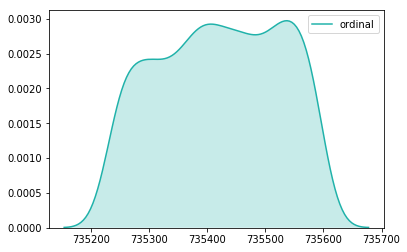

In [25]:
g = sns.kdeplot(accvehYes.ordinal, shade=True, color="lightseagreen")
plt.show()

The total number of accidents for right-hand driven vehicles was:

In [26]:
len(accvehYes.index)

1273

We observe that the manoeuvre involved in accidents is different for left and right-hand driven vehicles:

In [27]:
accvehNo = accveh[accveh['Was_Vehicle_Left_Hand_Drive?'] == 'No']

accvehYesGB = accvehYes.groupby('Vehicle_Manoeuvre').agg({ 'Accident_Index':'count'})/len(accvehYes)
accvehNoGB = accvehNo.groupby('Vehicle_Manoeuvre').agg({ 'Accident_Index':'count'})/len(accvehNo)

In [28]:
accvehYesGB.sort_values(by=['Accident_Index'], ascending = False).head(5)

,Accident_Index
Vehicle_Manoeuvre,
Going ahead other,0.376277
Changing lane to right,0.161822
Turning right,0.097408
Slowing or stopping,0.057345
Going ahead right-hand bend,0.044776


In [29]:
accvehNoGB.sort_values(by=['Accident_Index'], ascending = False).head(5)

,Accident_Index
Vehicle_Manoeuvre,
Going ahead other,0.468922
Turning right,0.103671
Slowing or stopping,0.078084
Waiting to go - held up,0.062956
Moving off,0.042010


Finally, we want to explore the differences in impact point:

### Point of impact of right-hand driven vehicles

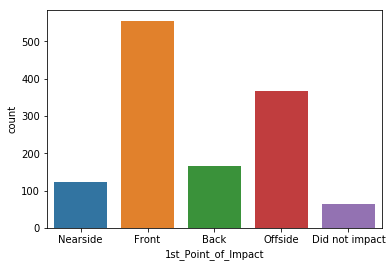

In [30]:
sns.countplot(data = accvehYes, x= accvehYes['1st_Point_of_Impact'], order = ['Nearside', 'Front', 'Back', 'Offside', 'Did not impact'])

### Point of impact of left-hand driven vehicles

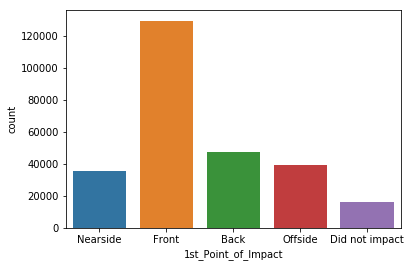

In [31]:
sns.countplot(data = accvehNo, x= accvehNo['1st_Point_of_Impact'][accvehNo['1st_Point_of_Impact'] != 'Data missing or out of range'], order = ['Nearside', 'Front', 'Back', 'Offside', 'Did not impact'])

## 4.1 Takeaway

The total number of accidents involving right-hand driven vehicles was 1273 in 2014.

Most of this accidents accured during late summer.

There are differences on the characteristics of the accidents involving left or right-hand driven vehicles:
    
- There is a big proportion of accidents when changing line to right for right-hand driven vehicles compared to left-hand vehicles. A potetntial explanation would be that right-hand vehicles have some problems of visibility on this side. 

- Right-hand driven vehicles impact more on the offside.

# 5. Does age affects severity of the accident?

We would expect that older people have more delicate health condition. Thus, accident severity should be greater for older people.

In [32]:
#we need all 3 datasets from 2014
allMerge = pd.merge(accveh,casualties)

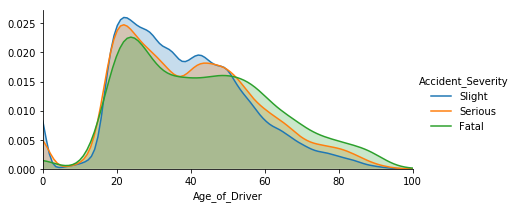

In [33]:
#Age by severity
g = sns.FacetGrid(allMerge, hue="Accident_Severity",aspect=2)
g.map(sns.kdeplot,'Age_of_Driver',shade= True)
g.set(xlim=(0, allMerge['Age_of_Driver'].max()))
g.add_legend()
plt.show()

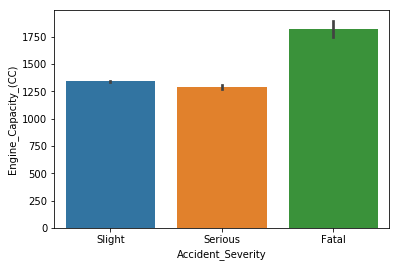

In [34]:
#Maybe other relevant variables also explain severity and they are correlated with age
#CC: more powerful cars are more dangerous, but they are only affordable for older people

sns.barplot(x='Accident_Severity',y="Engine_Capacity_(CC)", data=allMerge)
plt.show()

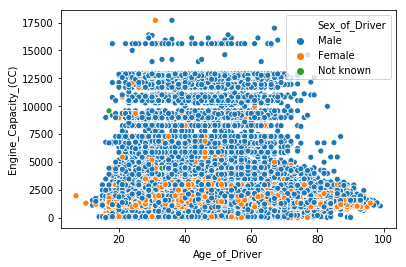

In [35]:
sns.scatterplot(x=vehicles.Age_of_Driver[vehicles.Age_of_Driver != -1], y = vehicles['Engine_Capacity_(CC)'][vehicles['Engine_Capacity_(CC)'] != -1], hue = vehicles.Sex_of_Driver)

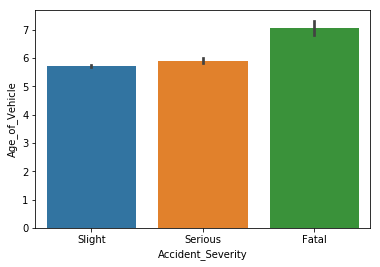

In [36]:
#Age of vehicle: we could expect age of vehicle to be larger for older drivers as they tend to keep vehicles they purchased earlier.
#Likewise, older vehicles may be less safe.
#Thus, the correlation between age of driver and severity might be also explained by age of vehicle

sns.barplot(x='Accident_Severity',y="Age_of_Vehicle", data=allMerge)
plt.show()

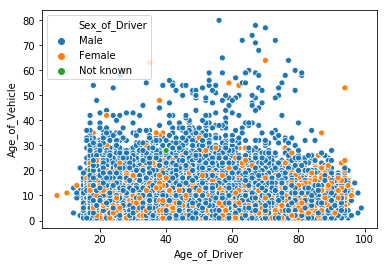

In [37]:
sns.scatterplot(x=vehicles.Age_of_Driver[vehicles.Age_of_Driver != -1], y = vehicles.Age_of_Vehicle[vehicles.Age_of_Vehicle != -1],  hue = vehicles.Sex_of_Driver)

## 5.1 Takeaway

In the first plot we found that older people had a grater proportion of 'Fatal' accidents. We might suspect that age influence on severity of the accident due to health conditions. 
However, we wanted to further exlore this idea to find any omitted variable that might be affecting both severity and age of the driver in the same direction.
we first analyse the relation between age of the driver and engine CC (graph 2). We suspect that older people can afford more powerful vehicles, which are also more dangerous as they can reach higher speed. Bigger engine capacities are restricted until the age of 65 approximately. It refers to trucks (with higher engine capacity) and age of retirement. If we focus on the right tail of the graph, we observe that older people do not tend to have the more powerful cars, neither the less ones. Hence, we cannot conclude that engine capacity is driving more severe accidents among older people.
In the third graph we analyzed the relation between age of the driver and age of the vehicle. We suspect that older people do not change their vehicles. Thus, they own older cars which are less secure.
we observe a tiny tendency of older people having the oldest cars (specially at the age of 60 to 80 years old). Nonotheless, this relation does not seem very strong.
In conclusion, we have observed a positive relation between severity of the accident and age of the driver. It does not appear to be any omitted variable bias. we did not find relevant differences among gender.

# 6. How does speed limit affect accidents?

In the next question, we are going to analyse the effect of speed limit on accidents. Our first hypothesis is that lower speed limit reduced number of accients. However, we will focuse also on the relation between severity of accident and speed limit.

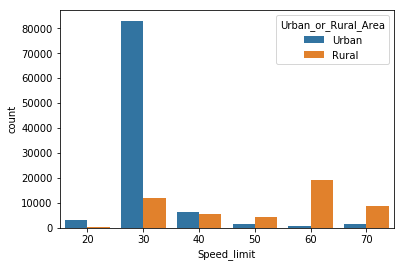

In [38]:
sns.countplot(data = accidents, x= accidents['Speed_limit'], hue = accidents['Urban_or_Rural_Area'] )

There are more accidents on 30 speed limit zone. However, it is highly influenced by the fact that most urban areas are 30 speed limit and the amount of traffic in that areas is higher.


In order to better understand how speed limit affect accidents, we focus our analysis on urban areas. 

In [39]:
#Let's explore urban area of London a little bit more in detail
df1 = accidents[accidents.Police_Force == 'Metropolitan Police'].groupby('Local_Authority_(District)').agg({'Speed_limit':'mean', 'Accident_Index':'count'})

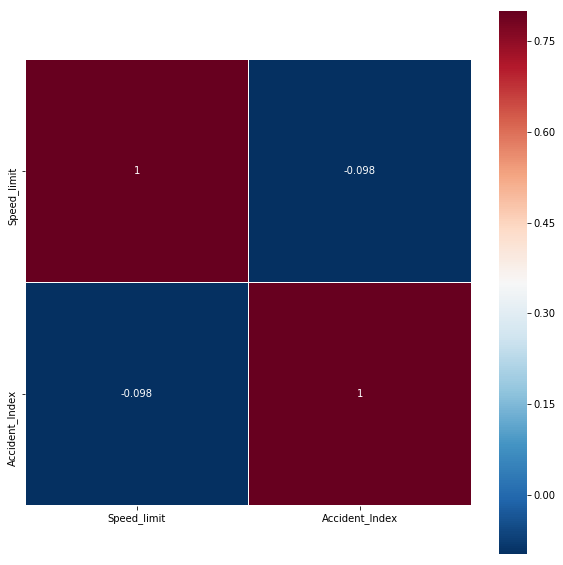

In [40]:
#Maybe different areas has different speed limits

corr=df1.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=.8, linewidths=0.01,
square=True,annot=True,cmap='RdBu_r',linecolor="white")

Even when limiting our analysis to London area, we still obtain contradictory results. In this case, speed limit and number of accidents are negatively correlated.
This result might be caused by the fact that there exists a huge heterogeneity in between districts in London.

Let's now turn to explore the relation between severity of accident and speed limit.

In [41]:
accsev = accidents.groupby(['Accident_Severity_numeric', 'Speed_limit']).agg({ 'Accident_Index':'count'})

In [42]:
accsev / accsev.groupby(level=0).sum()

Accident_Index
Accident_Severity_numeric Speed_limit                
1                         20                 0.016888
                          30                 0.355247
                          40                 0.082630
                          50                 0.076598
                          60                 0.353438
                          70                 0.115199
2                         20                 0.023796
                          30                 0.577191
                          40                 0.088654
                          50                 0.046334
                          60                 0.199458
                          70                 0.064568
3                         20                 0.023373
                          30                 0.665177
                          40                 0.081032
                          50                 0.038004
                          60                 0.123447
                          70                 0.068966

## 6.1 Takeaway

The analysis was highly influenced by urban areas, where speed limit is comonly 30.

Most accidents in urban areas are at a 30 speed limit while accidents in rural areas are at 60.

The analysis on London metropolitan area data was unconclusive. Speed limit analysis appears to be influenced by multiple factor difficult to control. To overcome this problem, a time series analysis could be performed: focusing the analysis on a single area (thus, controlling for multiple factors: traffic, characteristics of the streets...), we could analyse the evolution of mean speed limit in that area and compare it to the number of accidents. Moreover, we could focuse on an specific area (one street, junction...)to study the effect of a policy intervention,reducing speed limit.

When exploring the severity of the accidents, we observed that speed limit affects severity of the accident. Most accidents at 30 are 'Slight', while 'Fatal' accidents has a bigger proportion of 60 and 70 speed limit.

# 7 Does rainfall increase the probability of having an accident?

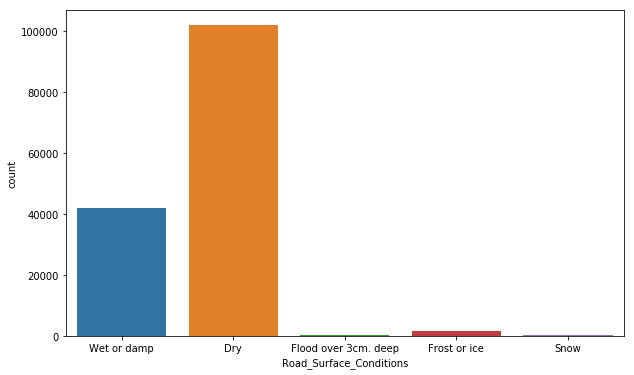

In [43]:
plt.figure(figsize=(10,6))
sns.countplot(data = accidents, x= accidents['Road_Surface_Conditions'][accidents['Road_Surface_Conditions']!= 'Data missing or out of range'])

According to this graph, we observe that the majority of the accidents take place at dry condition. However, we nedd to control for other factors such as rainy days compared to sunny days or changes of behaviour (maybe people do not take the motorbike, so there is less traffic). Moreover, the number of accidents under flood, ice or snow conditions seems to be irreevant for the purpose of this analysis. Hence, we will focuse on wet vs. dry conditions.

Let's explore the different behaviour that car drivers and motorbike riders have under different weather conditions. Our hypothesis is that, under wet conditions, riders accidents should be higher than car accidents because it is more difficult to ride under these conditions.
However, if we find that the proportion of accidents of riders on wet days vs. dry days is lower, we will conclude that, effectively, riders decide not to take the bike when raining.

In [44]:
accvehDWcar = accveh[(((accveh.Road_Surface_Conditions==('Dry')) | (accveh.Road_Surface_Conditions==('Wet or damp'))) & ((accveh.Vehicle_Type=='Car')))] 
DryVsWetcar = accvehDWcar.groupby('Road_Surface_Conditions').agg({'Accident_Index':'count'})/len(accvehDWcar)
accvehDWmb = accveh[(((accveh.Road_Surface_Conditions==('Dry')) | (accveh.Road_Surface_Conditions==('Wet or damp'))) & ((accveh.Vehicle_Type.str.contains('Motorcycle'))))] 
DryVsWetmb = accvehDWmb.groupby('Road_Surface_Conditions').agg({'Accident_Index':'count'})/len(accvehDWmb)
DryVsWetcar

,Accident_Index
Road_Surface_Conditions,
Dry,0.698655
Wet or damp,0.301345


In [45]:
DryVsWetmb

,Accident_Index
Road_Surface_Conditions,
Dry,0.735734
Wet or damp,0.264266


We can conclude that motorbike riders takes a more prudent behaviour and decide not to ride on rainy days. However, another potential explanation is that some riders switch from motorbike to car on rainy days.

We will finally analyse the effect of the amount of water on the probability of having an accident.

In [46]:
#regression mm vs accidents

In [62]:
accWin09_10 = accidentsAll[accidentsAll['Local_Authority_(District)'] == 'Winchester']
accWin09_10 ['Date'] = pd.to_datetime(accWin09_10 ['Date'], dayfirst = True)
accWin09_10['ordinal'] = accWin09_10['Date'].apply(lambda x: x.toordinal())
accWin09_10.sort_values(by=['ordinal'])

/home/gsitges/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/gsitges/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Accident_Index,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,...,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Severity_numeric,ordinal
142123,2005445HB0005,-1.180581,50.932140,Hampshire,Slight,2,2,2005-01-05,Wednesday,17:40,...,No physical crossing facilities within 50 metres,Darkness - no lighting,Fine no high winds,Dry,None,None,Rural,1,3,731951
142502,2005445OC0011,-1.164518,51.089846,Hampshire,Slight,2,1,2005-01-05,Wednesday,07:00,...,No physical crossing facilities within 50 metres,Darkness - lights lit,Fine no high winds,Wet or damp,None,None,Rural,1,3,731951
142503,2005445OC0014,-1.327154,51.030826,Hampshire,Slight,3,2,2005-01-06,Thursday,09:00,...,No physical crossing facilities within 50 metres,Daylight,Fine + high winds,Dry,None,None,Rural,1,3,731952
142504,2005445OC0020,-1.324662,51.045289,Hampshire,Slight,1,1,2005-01-06,Thursday,08:00,...,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Wet or damp,None,Previous accident,Urban,1,3,731952
142506,2005445OC0025,-1.327003,51.031365,Hampshire,Fatal,1,2,2005-01-06,Thursday,01:30,...,No physical crossing facilities within 50 metres,Darkness - no lighting,Fine no high winds,Dry,None,None,Rural,1,1,731952
142505,2005445OC0024,-1.336375,51.074132,Hampshire,Slight,1,1,2005-01-07,Friday,12:30,...,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Urban,2,3,731953
142507,2005445OC0029,-1.310420,51.062921,Hampshire,Slight,2,1,2005-01-09,Sunday,08:45,...,"Pelican, puffin, toucan or similar non-junctio...",Daylight,Fine no high winds,Dry,None,None,Urban,1,3,731955
142508,2005445OC0037,-1.292750,51.070639,Hampshire,Slight,3,1,2005-01-12,Wednesday,09:15,...,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Rural,1,3,731958
142509,2005445OC0038,-1.253575,51.119135,Hampshire,Slight,2,1,2005-01-12,Wednesday,08:25,...,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Rural,1,3,731958
142510,2005445OC0044,-1.320199,51.067565,Hampshire,Slight,2,1,2005-01-12,Wednesday,10:00,...,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Urban,2,3,731958


In [63]:
accWin09_10 = accWin09_10[(accWin09_10.ordinal>=733688) & (accWin09_10.ordinal<=734053)]
accWin09_10 = accWin09_10.groupby('ordinal').agg({ 'Accident_Index':'count'})
accWin09_10 = pd.DataFrame(accWin09_10)
accWin09_10 = accWin09_10.reset_index()
accWin09_10.columns = ['ordinal', 'accidents']
accWin09_10.head(5)

,ordinal,accidents
0,733688,1
1,733689,1
2,733690,1
3,733694,2
4,733695,1


In [64]:
#load weather data
#data is loaded from : https://data.gov.uk/dataset/53f6bf06-6a59-4722-a79e-a888d64e7164/meteorological-data-collected-at-micheldever-2009-2010

In [65]:
weather09_10 = pd.read_csv("../module-computing/Data_FULL-2005-2015/weather.csv")
weather09_10.columns = ['measure', 'date','sum','min','max','complete','comments']
weather09_10 = weather09_10[weather09_10['measure'] == 'Precipitation']
weather09_10['Date'] = pd.to_datetime(weather09_10['date'], dayfirst = True)
weather09_10['ordinal'] = weather09_10['Date'].apply(lambda x: x.toordinal())
weather09_10 = weather09_10[['sum','ordinal']]

In [66]:
weather09_10.head(5)

,sum,ordinal
433,0.0,733688
434,1.4,733689
435,0.2,733690
436,1.6,733691
437,0.0,733692


In [67]:
WeatherAcc = pd.merge(accWin09_10, weather09_10, left_on='ordinal', right_on='ordinal')

In [68]:
corr=WeatherAcc.corr()
corr

,ordinal,accidents,sum
ordinal,1.000000,-0.006082,-0.143424
accidents,-0.006082,1.000000,0.072709
sum,-0.143424,0.072709,1.000000


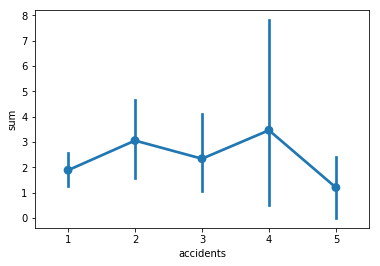

In [69]:
ax = sns.pointplot(x="accidents", y="sum", data=WeatherAcc)

## 7.1 Takeaway

In the first graph, we found that there were more accidents under 'Dry' conditions. However, it might be the case that there are more 'Dry' days during the year.
We also analyse the difference between car and motorcycle under wet and dry conditions. Althought we might expect higher proportion of accidents under wet conditions for motorbikes, we found the opposite result. Changes of riders behavior under wet conditions (they drive more carefully or they take another trasport) arises as a possible explanation. 
Finally, we further explored the effect of rainfall on accidents. We used data from Micheldever weather station. We needed daily data of rainfall from a weather station next to a city. Thus, Micheldever station and Winchester district appeared to be the best choice. 
We observe certain correlation between number of accidents and rainfall mm. However, this correlation does not appear to be very strong. In the graph we also observe that there is a higher number of accidents by day when it rains more (sum). This tendency does not hold for 5 accidents per day. We might consider them as outliers or too small data to make any conclusion about it.


# 8 Daylight condition

We want to understand the role of lighting in visibility and accidents. Potentially, address some policy recommendations.

In [70]:
acclight = accidents[accidents['Police_Force'] == 'Metropolitan Police'].groupby(['Local_Authority_(District)', 'Light_Conditions']).agg({ 'Accident_Index':'count'})

In [71]:
acclight = pd.DataFrame(acclight)
acclight = acclight.reset_index()
acclight

,Local_Authority_(District),Light_Conditions,Accident_Index
0,Barking and Dagenham,Darkness - lights lit,130
1,Barking and Dagenham,Darkness - lights unlit,1
2,Barking and Dagenham,Daylight,376
3,Barnet,Darkness - lighting unknown,32
4,Barnet,Darkness - lights lit,257
5,Barnet,Darkness - lights unlit,2
6,Barnet,Darkness - no lighting,3
7,Barnet,Daylight,689
8,Bexley,Darkness - lighting unknown,1
9,Bexley,Darkness - lights lit,80


In [72]:
acclightsums = acclight.groupby('Local_Authority_(District)').sum()


In [73]:
acclight2 = pd.merge(acclight, acclightsums, on='Local_Authority_(District)')
acclight2['proportions']=acclight2['Accident_Index_x']/acclight2['Accident_Index_y']
acclight2

,Local_Authority_(District),Light_Conditions,Accident_Index_x,Accident_Index_y,proportions
0,Barking and Dagenham,Darkness - lights lit,130,507,0.256410
1,Barking and Dagenham,Darkness - lights unlit,1,507,0.001972
2,Barking and Dagenham,Daylight,376,507,0.741617
3,Barnet,Darkness - lighting unknown,32,983,0.032553
4,Barnet,Darkness - lights lit,257,983,0.261445
5,Barnet,Darkness - lights unlit,2,983,0.002035
6,Barnet,Darkness - no lighting,3,983,0.003052
7,Barnet,Daylight,689,983,0.700916
8,Bexley,Darkness - lighting unknown,1,456,0.002193
9,Bexley,Darkness - lights lit,80,456,0.175439


In [81]:
acclight2[acclight2['proportions'] == acclight2['proportions'].max()]

,Local_Authority_(District),Light_Conditions,Accident_Index_x,Accident_Index_y,proportions
10,Bexley,Daylight,375,456,0.822368


Bexley is the district with higher proportion of accidents during the day.

In [83]:
acclight2[acclight2['proportions'] == acclight2['proportions'].where(acclight2['Light_Conditions']=='Darkness - lights lit').max()]

,Local_Authority_(District),Light_Conditions,Accident_Index_x,Accident_Index_y,proportions
122,Tower Hamlets,Darkness - lights lit,357,1044,0.341954


We suspect that Tower Hamlets might have some lighting issues as it is the district with higher proportion of accidents during the night.

In [96]:
accKC = accidents[(accidents['Local_Authority_(District)'] == 'Tower Hamlets') & (accidents['Light_Conditions'] == 'Darkness - lights lit')]


In [104]:
nightmap = folium.Map([51.520261, -0.04], 
               zoom_start=14)
locations = accKC[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()

marker_cluster = MarkerCluster().add_to(nightmap)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)

In [105]:
nightmap

## 8.1 Takeaway

We wanted to analyse the ffect of lighting conditions to the probability of having an accidents. We first computed the proportion of accidents at the different light conditions by district.
We observed that Bexley is the district with a higher proportion of accidents during the day. While, Tower Hamlets in London is the district with higher proportion of accidents at night. There are multiple causes to this fact:
 - Tower Hamlets has more night life. Hence, traffic is higher at night.
 - Light conditions in Tower Hamlets is poor.
 
We plotted the accidents during the night for the Tower Hamlets district in a map. We observe that the most dangerous zones during the night are:

 - Aldgate East
 - Whitechapel
 - Stepney green

# 9 Bicycle trends:

In [106]:
# merge of accidentsAll and vehiclesAll, accidentsAll and casualtiesAll
AccVehAll = pd.merge(accidentsAll, vehiclesAll)
AccCasAll = pd.merge(accidentsAll, casualtiesAll, left_on='Accident_Index', right_on='Accident_Index')

Has the number of accidents involving cyclist increased?

In [110]:
AccCasAllcy = AccCasAll.loc[:,['Casualty_Type', 'Date','Time','Accident_Index','Urban_or_Rural_Area']][AccCasAll.Casualty_Type == 'Cyclist']
AccCasAllcy['Datetime'] = pd.to_datetime(AccCasAllcy['Date'], dayfirst = True)
AccCasAllcy.index = AccCasAllcy['Datetime']

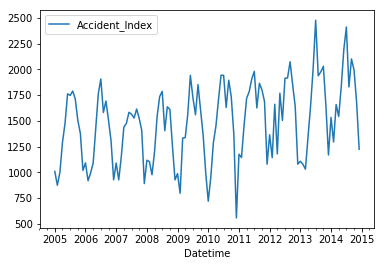

In [111]:
AccCasAllcy[['Accident_Index']].resample('M').agg({'Accident_Index':'count'}).plot()

### 9.1 Takeaway

We observe some seasonality on cyclist accidents. However, we also find a positive trend. The seasonality might be caused by the fact that, during cold month, less people choose the bicycle as the mean of transport.
The positive trend might be caused by the increasing popularity of bicycle.

We now want to explore where the bicycle has become more popular.

In [112]:
AccCasAllcyUrb = AccCasAllcy[AccCasAllcy.Urban_or_Rural_Area == 'Urban']
AccCasAllcyRur = AccCasAllcy[AccCasAllcy.Urban_or_Rural_Area == 'Rural']

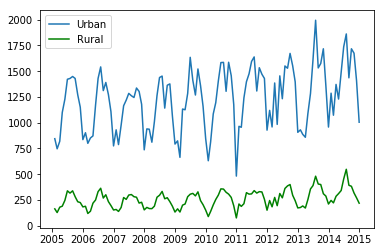

In [113]:
dataCU = AccCasAllcyUrb[['Accident_Index']].resample('M').agg({'Accident_Index':'count'})

dataCR = AccCasAllcyRur[['Accident_Index']].resample('M').agg({'Accident_Index':'count'})


urban, =plt.plot(dataCU,label='Urban')
rural, =plt.plot(dataCR,'g',label='Rural')
plt.legend()
plt.show()

## 9.2 Takeaway

Number of accidents in rural areas appears to be constant (just a small increase in the last years) while the number of accidents in urban areas has increased more (specially in the last years).

# 10 Vehicles trends

Does people purchase less powered vehicles (limited to cars)?

In [115]:
AccVehAllcc = AccVehAll.loc[:,['Engine_Capacity_(CC)', 'Date','Time','Accident_Index']][((AccVehAll['Engine_Capacity_(CC)'] != -1) & (AccVehAll['Vehicle_Type'] == 'Car'))]
AccVehAllcc['Datetime'] = pd.to_datetime(AccVehAllcc['Date'], dayfirst = True)


In [116]:
AccVehAllcc.index = AccVehAllcc['Datetime']

In [117]:
AccVehAllcc.head(5)

,Engine_Capacity_(CC),Date,Time,Accident_Index,Datetime
Datetime,,,,,
2005-01-06,1762,06/01/2005,00:15,200501BS00003,2005-01-06
2005-01-07,1769,07/01/2005,10:35,200501BS00004,2005-01-07
2005-01-11,2976,11/01/2005,12:40,200501BS00006,2005-01-11
2005-01-13,4266,13/01/2005,20:40,200501BS00007,2005-01-13
2005-01-14,5343,14/01/2005,17:35,200501BS00009,2005-01-14


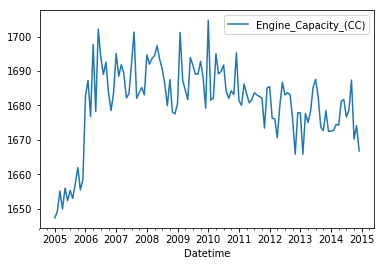

In [118]:
AccVehAllcc[['Engine_Capacity_(CC)']].resample('M').agg({'Engine_Capacity_(CC)':'mean'}).plot()

## 10.1 Takeaway

We observe a positive tendency until the beginning of the financial crisis (2007). At that point, mean CC starts decreasing over the years. It describes the tendency of the market to make smaller engines: more eco-friendly and less gas consuming.

Has the evolution of number of accidents been different in Rural and Urban areas?

In [119]:
accidentsAllUrb = accidentsAll.loc[:,['Date','Time','Accident_Index']][accidentsAll.Urban_or_Rural_Area == 'Urban']
accidentsAllUrb['Datetime'] = pd.to_datetime(accidentsAllUrb['Date'], dayfirst = True)
accidentsAllUrb.index = accidentsAllUrb['Datetime']

In [120]:
accidentsAllRur = accidentsAll.loc[:,['Date','Time','Accident_Index']][accidentsAll.Urban_or_Rural_Area == 'Rural']
accidentsAllRur['Datetime'] = pd.to_datetime(accidentsAllRur['Date'], dayfirst = True)
accidentsAllRur.index = accidentsAllRur['Datetime']

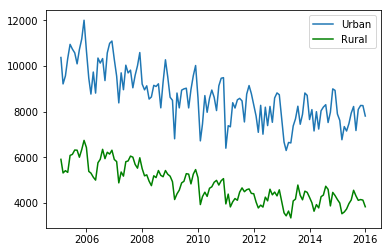

In [121]:

data1 = accidentsAllUrb[['Accident_Index']].resample('M').agg({'Accident_Index':'count'})

data2 = accidentsAllRur[['Accident_Index']].resample('M').agg({'Accident_Index':'count'})


urban, =plt.plot(data1,label='Urban')
rural, =plt.plot(data2,'g',label='Rural')
plt.legend()
plt.show()

## 10.2 Takeaway

We observe a similar tendency both in rural and urban areas. Accidents decreased from 2006 onwards. However, in the last years, it seems that the tendency has changed: in the last 3 years the number of accidents per year has been constant. 